# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from datetime import timedelta
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
from collections import OrderedDict
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import pickle

# Data Functions (will be moved to separate file)

In [3]:
def get_cpi():
    cpi = pd.read_excel('data/CPIAUCSL (1).xls')
    #cpi = pd.read_csv("T5YIE.csv")
    cpi.columns = ["date", 'CPI']
    cpi["date"] = pd.to_datetime(cpi["date"]) - timedelta(days=1)
    return cpi
    

def get_stocks():
    stocks = pd.read_csv("data/comp_stocks.csv")
    stocks["datadate"] = pd.to_datetime(stocks["datadate"])
    return stocks


def merge_cpi_stock(stocks, cpi):
    merged = pd.merge(stocks, cpi, how="left", left_on="MthCalDt", right_on="date")
    return merged

def bin_inflation_regimes(cpi, labels = ["deflation","low", "mid", "high"], bins = [-10, 0,1,3,20], value = "CPI", col = "Inflation"):
    cpi[col] = pd.cut(cpi[value],bins, labels=labels)
    return cpi


def get_percent_change(cpi):
    cpi["pct_change"] = cpi["CPI"].pct_change()
    return cpi

# get difference in inflation between two months
def get_inflation_diff(cpi, col = "CPI Diff", value = "CPI"):
    cpi[col] = cpi[value].diff()
    return cpi

def get_forecast():
    forecast = pd.read_csv("data/forecast.csv")
    # string of quarters to months 
    forecast["date"] = pd.to_datetime(forecast["TIME"])
    # sort by date
    forecast = forecast.sort_values(by="date")
    # get duplicate rows in forecast
    forecast[forecast.duplicated(subset=["date"], keep=False)]
    # forecast only for USA
    forecast = forecast[forecast["LOCATION"] == "USA"]

    # remove columns that have same value for all rows
    forecast = forecast.loc[:, forecast.apply(pd.Series.nunique) != 1]

    # remove flag codes columns
    forecast = forecast.loc[:, ~forecast.columns.str.contains('^Flag Codes')]
    return forecast

In [4]:
cpi = get_cpi()
cpi = get_inflation_diff(cpi)

In [5]:
cpi.dropna()

,date,CPI,CPI Diff
1,1948-01-31,9.48196,-0.76013
2,1948-02-29,6.81818,-2.66378
3,1948-03-31,8.27273,1.45455
4,1948-04-30,9.38497,1.11224
5,1948-05-31,9.37500,-0.00997
...,...,...,...
895,2022-07-31,8.22736,-0.18582
896,2022-08-31,8.21485,-0.01251
897,2022-09-30,7.76249,-0.45236
898,2022-10-31,7.13535,-0.62714


In [6]:
stocks = get_stocks()
# remove stocks with above 500 trt1m
stocks = stocks[stocks["trt1m"] < 1000]

# remove stocks with below -100 trt1m
stocks = stocks[stocks["trt1m"] > -100]
# drop na gics
stocks = stocks.dropna(subset=["ggroup","gind", "gsector", "gsubind"])
# drop missing trt1m
stocks = stocks.dropna(subset=["trt1m"])

# # drop stocks that have negative price
# stocks = stocks[stocks["prccm"] > 0]

# stocks["cshoq"] = stocks.groupby("gvkey")["cshoq"].ffill()

# # drop stocks that have negative shares
# stocks = stocks[stocks["cshoq"] > 0]

# # calculate market cap
# stocks["market_cap"] = stocks["prccm"] * stocks["cshoq"]
# print(stocks.shape)

# stocks["market_cap_shifted"] = stocks.groupby("gvkey")["market_cap"].shift(1) 

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_91633/3777490750.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stocks = pd.read_csv("data/comp_stocks.csv")


In [7]:
stocks.shape

(6394616, 22)

In [8]:
# get factors
def get_factors():

    ff_factors = pd.read_csv("data/ff_factors.csv")
    ff_factor_mom = pd.read_csv("data/ff_factor_umd.csv")
    ff_factors.rename({"Unnamed: 0": "date"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom":"UMD"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom   ":"UMD"}, axis=1, inplace=True)
    ff_factors = ff_factors.merge(ff_factor_mom, how="left", on="date")
    
    ff_factors["date"] = pd.to_datetime(ff_factors["date"], format="%Y%m")
    ff_factors["date"] += MonthEnd(0)


    return ff_factors

In [9]:
def get_company(stocks, gvkey, date):
    comp = stocks[(stocks["gvkey"] == gvkey) & (stocks["datadate"] <= date)]
    comp = comp.drop_duplicates(subset="datadate", keep="first")
    comp = comp.set_index("datadate")
    comp.index = comp.index + MonthEnd(0)

    return comp

In [10]:
def prep_reg(factors, comp_data, reg_factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "UMD", "CPI Diff"]):
    
    
    # add date to reg_factors
    reg_factors = ["date"] + reg_factors

    X = factors[reg_factors].set_index("date")

    comp_data["Excess Return"] = comp_data["trt1m"] - factors.set_index("date")["RF"]
    y = comp_data['Excess Return']
    

    # get indies that are the same between X and y
    indies_X = X.index.intersection(y.index)

    indies_y = y.index.intersection(X.index)

    indies = indies_X.intersection(indies_y)

    # save those rows
    X = X.loc[indies]
    y = y.loc[indies]
    
    return X, y

In [11]:
def run_reg(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [12]:
ff_factors = get_factors()

In [13]:
factors = pd.merge(cpi, ff_factors, how="inner", on="date")

In [14]:
# # stocks between 1990 and 2020
# stocks_set = stocks[stocks["datadate"] > "1989-06-01"] # six months needed for regression
# stocks_set = stocks_set[stocks_set["datadate"] < "2022-01-01"]

In [15]:
# stocks_set

,gvkey,iid,datadate,tic,cusip,conm,dvrate,cshtrm,prccm,trfm,...,cshom,exchg,cik,ggroup,gind,gsector,gsubind,sic,spcindcd,spcseccd
233,1003,01,1989-06-30,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.75,1.0,...,NaN,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
234,1003,01,1989-07-31,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.75,1.0,...,NaN,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
235,1003,01,1989-08-31,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.75,1.0,...,NaN,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
236,1003,01,1989-09-30,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.50,1.0,...,NaN,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
237,1003,01,1989-10-31,ANTQ,000354100,A.A. IMPORTING CO INC,NaN,NaN,0.75,1.0,...,NaN,19.0,730052.0,2550.0,255040.0,25.0,25504040.0,5712.0,449.0,976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7677700,351371,01C,2021-08-31,ODD.,67578E100,ODD BURGER CORP,NaN,807068.0,1.03,1.0,...,43904000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN
7677701,351371,01C,2021-09-30,ODD.,67578E100,ODD BURGER CORP,NaN,469383.0,0.90,1.0,...,82779000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN
7677702,351371,01C,2021-10-31,ODD.,67578E100,ODD BURGER CORP,NaN,230899.0,0.93,1.0,...,82779000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN
7677703,351371,01C,2021-11-30,ODD.,67578E100,ODD BURGER CORP,NaN,933891.0,0.57,1.0,...,82779000.0,9.0,1949766.0,2530.0,253010.0,25.0,25301040.0,5812.0,NaN,NaN


# Get Factors on reconstitution dates

In [17]:
# get dates that have the 3, 6, 9 and 12 month as dates
reconst_stock_dates = stocks[stocks["datadate"].dt.month.isin([3,6,9,12])]

In [18]:
gvkeys = reconst_stock_dates["gvkey"].unique()

In [19]:
dates_gvkeys = list(zip(reconst_stock_dates["datadate"], reconst_stock_dates["gvkey"]))

In [20]:
len(dates_gvkeys)

2131846

In [22]:
# save the betas
ff_factors = get_factors()

beta_dict = {}
t_dict = {}

for company in tqdm(dates_gvkeys):

    date = company[0]
    gvkey = company[1]

    # supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            company_data = get_company(stocks, gvkey, date)

            if len(company_data) < 6:
                continue

            X, y = prep_reg(factors, company_data)
            
            
            if (X.shape[0] < 2) or (y.shape[0] < 2):
                continue
                    
            reg_results = run_reg(X, y)
            
            # save betas and t stats
            beta_dict[company] = reg_results.params.to_dict()
            t_dict[company] = reg_results.tvalues.to_dict()
                        

            # save dict to a file every 10000 iterations using pickle not json
            if len(beta_dict) % 10000 == 0:
                with open('beta_dict_w_factors_1990.pickle', 'wb') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump(beta_dict, f, pickle.HIGHEST_PROTOCOL)            
                
                with open('t_dict_w_factors_1990.pickle', 'wb') as f:
                # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump(t_dict, f, pickle.HIGHEST_PROTOCOL)    
                   
   
        except ValueError:
            print("ValueError for gvkey: ", company)
            break
    

100%|██████████| 2131846/2131846 [10:35:06<00:00, 55.94it/s]  


In [21]:
# read in the saved dict
with open('t_dict_w_factors.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    beta_dict = pickle.load(f)

# read in the saved dict
with open('t_dict_w_factors_1990.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    t_dict = pickle.load(f)

In [23]:
beta_df = pd.DataFrame.from_dict(beta_dict, orient="index")

In [24]:
beta_df

,,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff
1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491
1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795
1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742
1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071
1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161
...,...,...,...,...,...,...,...,...,...
2022-06-30,351590,-2.024693,2.301945,0.231034,1.831006,4.158512,-1.592552,0.775537,0.173058
2022-09-30,351590,-14.698540,2.770672,14.970408,7.275495,2.357234,4.499387,-0.544222,-119.320140
2022-12-31,351590,-3.185057,1.219273,-0.633016,1.428794,1.528512,-0.964526,0.855251,-3.360601
2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518


In [25]:
t_df = pd.DataFrame.from_dict(t_dict, orient="index")

In [26]:
t_df

,,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff
1984-03-31,1001,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
1984-06-30,1001,-2.943242,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972
1984-09-30,1001,-1.068479,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423
1984-12-31,1001,-0.805006,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480
1985-03-31,1001,-0.013529,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519
...,...,...,...,...,...,...,...,...,...
2022-06-30,351590,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
2022-09-30,351590,-7.563526,8.676555,4.763186,7.578787,4.867750,2.962496,-0.765615,-5.012546
2022-12-31,351590,-0.784805,1.935301,-0.285725,1.024656,1.187970,-0.491287,0.465799,-0.310724
2022-09-30,352257,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000


In [27]:
# put _t_stat at the end of the t stats
t_df.columns = [col + "_t_stat" for col in t_df.columns]

beta_t_df = pd.merge(beta_df, t_df, how="inner", left_index=True, right_index=True)


In [28]:
beta_t_df = beta_t_df.reset_index()

# rename level_0 to date and level_1 to gvkey
beta_t_df.rename({"level_0": "date", "level_1": "gvkey"}, axis=1, inplace=True)

beta_t_df

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
1,1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795,-2.943242,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972
2,1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742,-1.068479,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423
3,1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071,-0.805006,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480
4,1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161,-0.013529,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923648,2022-06-30,351590,-2.024693,2.301945,0.231034,1.831006,4.158512,-1.592552,0.775537,0.173058,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
1923649,2022-09-30,351590,-14.698540,2.770672,14.970408,7.275495,2.357234,4.499387,-0.544222,-119.320140,-7.563526,8.676555,4.763186,7.578787,4.867750,2.962496,-0.765615,-5.012546
1923650,2022-12-31,351590,-3.185057,1.219273,-0.633016,1.428794,1.528512,-0.964526,0.855251,-3.360601,-0.784805,1.935301,-0.285725,1.024656,1.187970,-0.491287,0.465799,-0.310724
1923651,2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000


# Fundamental Data (Unused)

In [527]:
#funda = pd.read_csv("data/funda.csv")

In [217]:
''' 
Standard and Poor's Identifier (GVKEY)

Company Name (CONM)

Ticker Symbol (TIC)

CHQ -- Cash (CHQ)

DD1Q -- Long-Term Debt Due in One Year (DD1Q)

DLCQ -- Debt in Current Liabilities (DLCQ)

DLTTQ -- Long-Term Debt - Total (DLTTQ)

IVLTQ -- Total Long-term Investments (IVLTQ)

IVSTQ -- Short-Term Investments- Total (IVSTQ)

XOPRQ -- Operating Expense- Total (XOPRQ)

DLCCHY -- Changes in Current Debt (DLCCHY)

'''

" \nStandard and Poor's Identifier (GVKEY)\n\nCompany Name (CONM)\n\nTicker Symbol (TIC)\n\nCHQ -- Cash (CHQ)\n\nDD1Q -- Long-Term Debt Due in One Year (DD1Q)\n\nDLCQ -- Debt in Current Liabilities (DLCQ)\n\nDLTTQ -- Long-Term Debt - Total (DLTTQ)\n\nIVLTQ -- Total Long-term Investments (IVLTQ)\n\nIVSTQ -- Short-Term Investments- Total (IVSTQ)\n\nXOPRQ -- Operating Expense- Total (XOPRQ)\n\nDLCCHY -- Changes in Current Debt (DLCCHY)\n\n"

In [223]:
# funda.rename({  "chq":"Cash", 
#                 "dd1q":"Long-Term Debt Due in One Year", 
#                 "dlcq":"Debt in Current Liabilities", 
#                 "dlttq":"Long-Term Debt - Total", 
#                 "ivltq":"Total Long-term Investments", 
#                 "ivstq":"Short-Term Investments- Total", 
#                 "xoprq":"Operating Expense- Total", 
#                 "dlcchy":"Changes in Current Debt", 
#                 "mkvaltq":"Market Value - Total",
#                 "atq":"Assets - Total",
#                 "revty" : "Revenue - Total",                
#                 }, axis=1, inplace=True)

In [224]:
#funda.columns

Index(['GVKEY', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc',
       'datafmt', 'tic', 'conm', 'curcdq', 'datacqtr', 'datafqtr',
       'Assets - Total', 'Cash', 'Long-Term Debt Due in One Year',
       'Debt in Current Liabilities', 'Long-Term Debt - Total',
       'Total Long-term Investments', 'Short-Term Investments- Total',
       'Operating Expense- Total', 'Changes in Current Debt',
       'Revenue - Total', 'costat', 'Market Value - Total'],
      dtype='object')

In [225]:
# # add 3 months to datadate and call that report date
# funda["datadate"] = pd.to_datetime(funda["datadate"])
# funda["report date"] = funda["datadate"] + MonthEnd(3)


In [226]:
# funda["Long-Term Debt Due in One Year Percent"] = funda["Long-Term Debt Due in One Year"] / funda["Long-Term Debt - Total"]

# funda["Long-Term Debt Percent"] = funda["Long-Term Debt - Total"] / (funda["Debt in Current Liabilities"] + funda["Long-Term Debt - Total"])
# funda["Short-Term Debt Percent"] = funda["Debt in Current Liabilities"] / (funda["Debt in Current Liabilities"] + funda["Long-Term Debt - Total"])

# funda["Cash Percent"] = funda["Cash"] / (funda["Cash"] + funda["Short-Term Investments- Total"] + funda["Total Long-term Investments"])

# funda["Total Long-term Investments Percent"] = funda["Total Long-term Investments"] / (funda["Short-Term Investments- Total"] + funda["Total Long-term Investments"])
# funda["Total Short-term Investments Percent"] = funda["Short-Term Investments- Total"] / (funda["Short-Term Investments- Total"] + funda["Total Long-term Investments"])

# funda["Operating Expense Ratio"] = funda["Operating Expense- Total"] / funda["Revenue - Total"]

In [227]:
# funda.isna().sum()

GVKEY                                           0
datadate                                        0
fyearq                                          0
fqtr                                            0
indfmt                                          0
consol                                          0
popsrc                                          0
datafmt                                         0
tic                                             1
conm                                            0
curcdq                                          0
datacqtr                                     1653
datafqtr                                        0
Assets - Total                             186220
Cash                                       905940
Long-Term Debt Due in One Year            1042002
Debt in Current Liabilities                231829
Long-Term Debt - Total                     169929
Total Long-term Investments                864789
Short-Term Investments- Total              919081


In [230]:
# keep = ["GVKEY", "report date", "Long-Term Debt Due in One Year Percent", "Long-Term Debt Percent", "Short-Term Debt Percent", "Cash Percent", "Total Long-term Investments Percent", "Total Short-term Investments Percent", "Operating Expense Ratio"]

In [231]:
# funda = funda[keep]

In [232]:
# beta_t_df

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
0,2004-12-31,1003,-0.138276,0.010059,0.026984,-0.061919,0.058570,-0.023065,-0.011800,0.047869,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
1,2005-03-31,1003,-0.128774,-0.000035,0.025105,-0.030315,0.033886,-0.007313,-0.011879,0.049594,-5.186306,-0.004412,3.084612,-1.407134,3.027088,-0.714596,-1.901116,1.137301
2,2005-06-30,1003,-0.172917,0.015876,-0.003249,-0.014142,0.024544,-0.022686,-0.004496,0.053990,-4.505061,0.840367,-0.169640,-0.395787,0.822088,-0.818753,-0.409248,0.808658
3,2005-09-30,1003,-4.404246,-0.161192,3.786756,-0.675228,4.244383,1.366785,-5.363642,24.304606,-0.274062,-0.020287,0.498944,-0.051760,0.418794,0.116777,-1.328682,1.125379
4,2005-12-31,1003,1.710249,50.739537,-37.328633,-35.158119,23.551260,-54.783362,-2.179491,90.876421,0.015951,0.907953,-0.690888,-0.418940,0.352811,-0.714882,-0.073614,0.626448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887961,2020-06-30,351371,1.007001,-0.562695,0.472423,-2.891656,1.111710,3.695034,-0.637119,-16.713177,0.301386,-0.517154,0.303431,-2.031784,0.403230,1.576806,-0.491899,-1.257836
887962,2020-09-30,351371,-0.076496,-0.352193,0.204517,-3.079972,1.316744,4.450750,-0.796219,-15.295812,-0.023036,-0.348261,0.132894,-2.181391,0.517083,1.983909,-0.660186,-1.143765
887963,2020-12-31,351371,0.346961,-0.484835,0.366771,-2.896275,1.409507,4.159801,-0.774811,-15.765458,0.111898,-0.526175,0.254703,-2.206601,0.603026,2.001226,-0.694291,-1.226978
887964,2021-03-31,351371,1.383455,-0.983350,0.383224,-2.814162,1.866016,3.531918,-1.184866,-7.701344,0.468713,-1.205338,0.280531,-2.233176,0.916113,1.987475,-1.205937,-0.772601


In [233]:
# merge beta_t_df with funda on gvkey and report date
# beta_t_funda = pd.merge(beta_t_df, funda, how="inner", left_on=["date", "gvkey"], right_on=["report date", "GVKEY"])

In [234]:
# find sigificant betas for cpi diff
# beta_t_funda[abs(beta_t_funda["CPI Diff_t_stat"]) > 3]

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,CPI Diff_t_stat,GVKEY,report date,Long-Term Debt Due in One Year Percent,Long-Term Debt Percent,Short-Term Debt Percent,Cash Percent,Total Long-term Investments Percent,Total Short-term Investments Percent,Operating Expense Ratio
227,2005-03-31,1075,-4.877035,1.659626,0.846775,5.324797,-0.607216,-0.690056,-2.170726,11.229796,...,4.097631,1075,2005-03-31,NaN,0.789747,0.210253,NaN,NaN,NaN,0.181979
765,2005-03-31,1161,-14.176924,8.591560,5.612353,10.185375,3.366672,2.989373,-5.962305,53.887539,...,3.012727,1161,2005-03-31,NaN,0.875839,0.124161,NaN,NaN,NaN,0.182326
883,2005-03-31,1177,-10.514585,5.140738,-2.450534,13.354668,-4.502885,-4.748124,0.077585,3.740382,...,3.242902,1177,2005-03-31,NaN,1.000000,0.000000,NaN,NaN,NaN,0.230319
939,2005-03-31,1186,-16.754353,6.151968,-0.628416,11.314410,1.681008,-1.241984,-2.786355,41.032344,...,4.309442,1186,2005-03-31,NaN,1.000000,0.000000,NaN,NaN,NaN,0.134375
940,2005-06-30,1186,-6.106419,3.768420,-2.653889,2.721909,1.663432,-0.333178,0.144453,19.543607,...,3.128059,1186,2005-06-30,NaN,1.000000,0.000000,NaN,NaN,NaN,0.620600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318198,2021-09-30,325867,-13.903822,1.408790,4.816038,-3.840893,-0.644892,-4.279749,1.979693,26.251782,...,3.574284,325867,2021-09-30,1.592120,0.385785,0.614215,0.983808,1.00000,0.00000,31.953743
318226,2021-06-30,327451,-1.190008,0.399515,0.100292,0.341832,-2.353779,0.350497,0.529072,23.514010,...,3.089160,327451,2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,0.695506
318235,2019-09-30,328032,-6.223484,1.561390,-8.194390,3.658133,-8.776432,-1.763235,-0.203901,29.589727,...,420.734056,328032,2019-09-30,0.243789,0.803995,0.196005,0.605030,0.82828,0.17172,0.325859
318260,2019-12-31,330227,-11.036212,-5.695396,6.019047,5.048371,26.685688,-17.511926,3.153702,119.517747,...,4.180521,330227,2019-12-31,0.000000,1.000000,0.000000,1.000000,NaN,NaN,0.248241


In [236]:
beta_t_funda.isna().sum()

date                                           0
gvkey                                          0
const                                          0
Mkt-RF                                         0
SMB                                            0
HML                                            0
RMW                                            0
CMA                                            0
UMD                                            0
CPI Diff                                       0
const_t_stat                                   0
Mkt-RF_t_stat                                  0
SMB_t_stat                                     0
HML_t_stat                                     0
RMW_t_stat                                     0
CMA_t_stat                                     0
UMD_t_stat                                     0
CPI Diff_t_stat                                0
GVKEY                                          0
report date                                    0
Long-Term Debt Due i

In [247]:
temp = beta_t_funda.dropna()

In [248]:
temp = temp[abs(temp["CPI Diff_t_stat"]) > 2]

<AxesSubplot:>

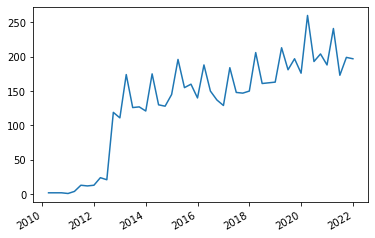

In [249]:
# plot count of significant t stats postive and negative by date
temp["date"].value_counts().plot()

# Macros

In [29]:
# read in GDP
gdp = pd.read_csv("data/GDP.csv")

unemployment = pd.read_excel("data/UNRATE.xls")

corp_profits = pd.read_excel("data/CP.xls")

# read in FEDFUND
fedfund = pd.read_csv("data/FEDFUNDS.csv")

In [30]:
# add 3 months to date and call that report date
unemployment["observation_date"] = pd.to_datetime(unemployment["observation_date"])

unemployment["report date"] = unemployment["observation_date"] + MonthEnd(3)

# drop observation date
unemployment.drop("observation_date", axis=1, inplace=True)

In [31]:
corp_profits["observation_date"] = pd.to_datetime(corp_profits["observation_date"])

corp_profits["report date"] = corp_profits["observation_date"] + MonthEnd(3)
corp_profits.drop("observation_date", axis=1, inplace=True)

In [32]:
gdp["DATE"] = pd.to_datetime(gdp["DATE"])
gdp["report date"] = gdp["DATE"] + MonthEnd(3)
gdp.drop("DATE", axis=1, inplace=True)

In [33]:
# report date is the end of the month 
fedfund["DATE"] = pd.to_datetime(fedfund["DATE"])
fedfund["report date"] = fedfund["DATE"] + MonthEnd(0)
fedfund.drop("DATE", axis=1, inplace=True)

In [34]:
# merge corp_profits with unemployment with gdp with fedfund on report date
macros = pd.merge(corp_profits, unemployment, how="inner", left_on="report date", right_on="report date")
macros = pd.merge(macros, gdp, how="inner", left_on="report date", right_on="report date")
macros = pd.merge(macros, fedfund, how="inner", left_on="report date", right_on="report date")

In [35]:
macros

,CP,report date,UNRATE,GDP,FEDFUNDS
0,23.813,1954-09-30,5.966667,390.996,1.07
1,25.515,1954-12-31,5.333333,399.734,1.28
2,28.583,1955-03-31,4.733333,413.073,1.35
3,29.064,1955-06-30,4.400000,421.532,1.64
4,29.843,1955-09-30,4.100000,430.221,2.18
...,...,...,...,...,...
268,2827.118,2021-09-30,5.133333,23550.420,0.08
269,2760.777,2021-12-31,4.200000,24349.121,0.08
270,2833.431,2022-03-31,3.800000,24740.480,0.20
271,3043.114,2022-06-30,3.600000,25248.476,1.21


In [36]:
beta_t_df

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
1,1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795,-2.943242,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972
2,1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742,-1.068479,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423
3,1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071,-0.805006,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480
4,1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161,-0.013529,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923648,2022-06-30,351590,-2.024693,2.301945,0.231034,1.831006,4.158512,-1.592552,0.775537,0.173058,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
1923649,2022-09-30,351590,-14.698540,2.770672,14.970408,7.275495,2.357234,4.499387,-0.544222,-119.320140,-7.563526,8.676555,4.763186,7.578787,4.867750,2.962496,-0.765615,-5.012546
1923650,2022-12-31,351590,-3.185057,1.219273,-0.633016,1.428794,1.528512,-0.964526,0.855251,-3.360601,-0.784805,1.935301,-0.285725,1.024656,1.187970,-0.491287,0.465799,-0.310724
1923651,2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000


In [37]:
stocks

,gvkey,iid,datadate,tic,cusip,conm,dvrate,cshtrm,prccm,trfm,...,cshom,exchg,cik,ggroup,gind,gsector,gsubind,sic,spcindcd,spcseccd
96,1001,01,1983-10-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,370700.0,6.750,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
97,1001,01,1983-11-30,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,198000.0,8.000,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
98,1001,01,1983-12-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,176500.0,7.250,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
99,1001,01,1984-01-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,160800.0,8.000,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
100,1001,01,1984-02-29,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,92400.0,6.500,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7677798,353444,90,2022-12-31,HLN,405552100,HALEON PLC,NaN,199074059.0,8.000,1.0,...,9.234574e+09,11.0,NaN,3030.0,303020.0,30.0,30302010.0,2834.0,NaN,NaN
7677799,353444,90,2023-01-31,HLN,405552100,HALEON PLC,NaN,76238800.0,8.100,1.0,...,9.234574e+09,11.0,NaN,3030.0,303020.0,30.0,30302010.0,2834.0,NaN,NaN
7677801,353945,90,2022-11-30,ACLLY,00449R109,ACCELLERON INDUSTRIES AG,NaN,NaN,20.178,1.0,...,9.450000e+07,19.0,1948862.0,2010.0,201040.0,20.0,20104020.0,3621.0,NaN,NaN
7677802,353945,90,2022-12-31,ACLLY,00449R109,ACCELLERON INDUSTRIES AG,NaN,NaN,20.693,1.0,...,9.450000e+07,19.0,1948862.0,2010.0,201040.0,20.0,20104020.0,3621.0,NaN,NaN


In [38]:
beta_t_price = pd.merge(beta_t_df, stocks[["gvkey", "datadate", "prccm"]], how="left", left_on=["gvkey", "date"], right_on=["gvkey", "datadate"])

In [39]:
beta_t_price.head()

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,datadate,prccm
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,1984-03-31,6.375
1,1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795,-2.943242,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972,1984-06-30,5.750
2,1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742,-1.068479,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423,1984-09-30,4.625
3,1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071,-0.805006,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480,1984-12-31,3.750
4,1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161,-0.013529,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519,1985-03-31,5.500


In [40]:
# shift price back groupby gvkey
beta_t_price["next prccm"] = beta_t_price.groupby("gvkey")["prccm"].shift(-1)

In [41]:
beta_t_price.head()

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,datadate,prccm,next prccm
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,1984-03-31,6.375,5.750
1,1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795,...,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972,1984-06-30,5.750,4.625
2,1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742,...,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423,1984-09-30,4.625,3.750
3,1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071,...,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480,1984-12-31,3.750,5.500
4,1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161,...,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519,1985-03-31,5.500,6.500


In [42]:
# drop na in next prccm
beta_t_price = beta_t_price.dropna()

In [43]:
# drop datadate
beta_t_price.drop("datadate", axis=1, inplace=True)

In [44]:
beta_t_price

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,prccm,next prccm
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,6.3750,5.7500
1,1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795,-2.943242,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972,5.7500,4.6250
2,1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742,-1.068479,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423,4.6250,3.7500
3,1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071,-0.805006,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480,3.7500,5.5000
4,1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161,-0.013529,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519,5.5000,6.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067452,2022-06-30,351590,-2.024693,2.301945,0.231034,1.831006,4.158512,-1.592552,0.775537,0.173058,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,13.0210,11.4370
2067453,2022-09-30,351590,-14.698540,2.770672,14.970408,7.275495,2.357234,4.499387,-0.544222,-119.320140,-7.563526,8.676555,4.763186,7.578787,4.867750,2.962496,-0.765615,-5.012546,11.4370,15.4460
2067455,2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.4866,0.6400
2067456,2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.6400,0.2877


In [45]:
# merge beta_t_price with macros on report date
beta_t_price_macros = pd.merge(beta_t_price, macros, how="inner", left_on="date", right_on="report date")

In [46]:
beta_t_price_macros

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,prccm,next prccm,CP,report date,UNRATE,GDP,FEDFUNDS
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,...,0.000000,-0.000000,0.000000,6.375,5.750,220.108,1984-03-31,7.866667,3908.054,9.91
1,1984-03-31,1004,0.289573,0.937900,0.919034,-0.477545,0.732247,1.023749,0.013793,-0.831650,...,1.372462,0.061387,-0.429041,20.000,20.375,220.108,1984-03-31,7.866667,3908.054,9.91
2,1984-03-31,1007,-2.498128,0.648195,1.031204,-1.032990,-1.159911,1.761330,-0.028730,7.028076,...,1.396593,-0.082227,2.713481,0.500,0.500,220.108,1984-03-31,7.866667,3908.054,9.91
3,1984-03-31,1008,23.568822,-12.176207,13.407248,-0.973918,-5.125546,-20.888023,-8.371745,-23.207184,...,-0.000000,-0.000000,-0.000000,1.375,2.375,220.108,1984-03-31,7.866667,3908.054,9.91
4,1984-03-31,1009,9.120035,-2.101597,2.863629,-2.218818,-6.413271,-1.378303,-4.315057,0.353089,...,-0.280632,-2.559907,0.035218,5.750,6.000,220.108,1984-03-31,7.866667,3908.054,9.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006589,1968-09-30,65095,-0.399711,0.424707,0.183354,0.562789,0.388250,0.092256,-0.434305,-0.744966,...,0.229765,-2.255352,-0.376719,19.380,21.130,61.024,1968-09-30,3.533333,950.825,5.78
2006590,1968-09-30,65298,-0.035666,0.653346,-0.030950,-0.607587,-0.085618,0.764880,-0.315337,0.501194,...,1.695139,-1.457193,0.225533,24.000,27.380,61.024,1968-09-30,3.533333,950.825,5.78
2006591,1968-09-30,65499,-2.109983,1.388528,-0.050112,3.819878,3.839351,1.539229,1.051890,17.620690,...,0.539785,0.844734,1.358660,15.127,20.002,61.024,1968-09-30,3.533333,950.825,5.78
2006592,1968-09-30,66430,-0.118772,1.008584,0.506927,0.945282,0.858538,0.113610,-0.592992,1.098971,...,0.137480,-1.496241,0.270022,87.499,95.249,61.024,1968-09-30,3.533333,950.825,5.78


In [47]:
# target is if next price is greater than current price as one
beta_t_price_macros["target"] = beta_t_price_macros["next prccm"] > beta_t_price_macros["prccm"]

# true false to one and zero
beta_t_price_macros["target"] = beta_t_price_macros["target"].astype(int)

In [48]:
beta_t_price_macros

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,UMD_t_stat,CPI Diff_t_stat,prccm,next prccm,CP,report date,UNRATE,GDP,FEDFUNDS,target
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,...,-0.000000,0.000000,6.375,5.750,220.108,1984-03-31,7.866667,3908.054,9.91,0
1,1984-03-31,1004,0.289573,0.937900,0.919034,-0.477545,0.732247,1.023749,0.013793,-0.831650,...,0.061387,-0.429041,20.000,20.375,220.108,1984-03-31,7.866667,3908.054,9.91,1
2,1984-03-31,1007,-2.498128,0.648195,1.031204,-1.032990,-1.159911,1.761330,-0.028730,7.028076,...,-0.082227,2.713481,0.500,0.500,220.108,1984-03-31,7.866667,3908.054,9.91,0
3,1984-03-31,1008,23.568822,-12.176207,13.407248,-0.973918,-5.125546,-20.888023,-8.371745,-23.207184,...,-0.000000,-0.000000,1.375,2.375,220.108,1984-03-31,7.866667,3908.054,9.91,1
4,1984-03-31,1009,9.120035,-2.101597,2.863629,-2.218818,-6.413271,-1.378303,-4.315057,0.353089,...,-2.559907,0.035218,5.750,6.000,220.108,1984-03-31,7.866667,3908.054,9.91,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006589,1968-09-30,65095,-0.399711,0.424707,0.183354,0.562789,0.388250,0.092256,-0.434305,-0.744966,...,-2.255352,-0.376719,19.380,21.130,61.024,1968-09-30,3.533333,950.825,5.78,1
2006590,1968-09-30,65298,-0.035666,0.653346,-0.030950,-0.607587,-0.085618,0.764880,-0.315337,0.501194,...,-1.457193,0.225533,24.000,27.380,61.024,1968-09-30,3.533333,950.825,5.78,1
2006591,1968-09-30,65499,-2.109983,1.388528,-0.050112,3.819878,3.839351,1.539229,1.051890,17.620690,...,0.844734,1.358660,15.127,20.002,61.024,1968-09-30,3.533333,950.825,5.78,1
2006592,1968-09-30,66430,-0.118772,1.008584,0.506927,0.945282,0.858538,0.113610,-0.592992,1.098971,...,-1.496241,0.270022,87.499,95.249,61.024,1968-09-30,3.533333,950.825,5.78,1


In [49]:
# get value counts of target
beta_t_price_macros["target"].value_counts()

0    1074316
1     932278
Name: target, dtype: int64

In [50]:
beta_t_price_macros.columns

Index(['date', 'gvkey', 'const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD',
       'CPI Diff', 'const_t_stat', 'Mkt-RF_t_stat', 'SMB_t_stat', 'HML_t_stat',
       'RMW_t_stat', 'CMA_t_stat', 'UMD_t_stat', 'CPI Diff_t_stat', 'prccm',
       'next prccm', 'CP', 'report date', 'UNRATE', 'GDP', 'FEDFUNDS',
       'target'],
      dtype='object')

# Ratios/Industry

In [51]:
#stocks_industry = stocks[{"gvkey", "ggroup"}].merge(gics[["IndustryGroup", "IndustryGroupId"]], how="left", left_on="ggroup", right_on="IndustryGroupId").drop_duplicates()

In [52]:
#stocks_industry

In [53]:
ratios = pd.read_csv("data/ratios.csv")

In [54]:
ratios = ratios.fillna(0)

In [55]:
ratios

,gvkey,permno,adate,qdate,public_date,dpr,opmad,roa,roe,GProf,short_debt,de_ratio,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,staff_sale,divyield,TICKER
0,1004,54594,05/31/1989,11/30/1989,01/31/1990,0.270,0.115,0.164,0.136,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.0,1.52%,AIR
1,1004,54594,05/31/1989,11/30/1989,02/28/1990,0.270,0.115,0.164,0.136,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.0,1.54%,AIR
2,1004,54594,05/31/1989,11/30/1989,03/31/1990,0.270,0.115,0.164,0.136,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.0,1.60%,AIR
3,1004,54594,05/31/1989,02/28/1990,04/30/1990,0.269,0.113,0.161,0.131,0.305,0.524,1.063,5.002,0.043,1.085,2.455,0.0,2.22%,AIR
4,1004,54594,05/31/1989,02/28/1990,05/31/1990,0.269,0.113,0.161,0.131,0.305,0.524,1.063,5.002,0.043,1.085,2.455,0.0,2.26%,AIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932439,349972,15642,12/31/2021,06/30/2022,08/31/2022,0.000,0.000,-0.342,-0.377,0.000,0.657,0.130,0.000,8.491,8.732,8.732,0.0,0,INDP
1932440,349972,15642,12/31/2021,06/30/2022,09/30/2022,0.000,0.000,-0.342,-0.377,0.000,0.657,0.130,0.000,8.491,8.732,8.732,0.0,0,INDP
1932441,349972,15642,12/31/2021,06/30/2022,10/31/2022,0.000,0.000,-0.342,-0.377,0.000,0.657,0.130,0.000,8.491,8.732,8.732,0.0,0,INDP
1932442,349972,15642,12/31/2021,09/30/2022,11/30/2022,0.000,0.000,-0.361,-0.403,0.000,0.713,0.117,0.000,9.250,9.479,9.479,0.0,0,INDP


In [625]:
'''
Dividend Payout Ratio (dpr)

Operating Profit Margin After Depreciation (opmad)

Return on Assets (roa)

Return on Equity (roe)

Gross Profit/Total Assets (GProf)

Short-Term Debt/Total Debt (short_debt)

Total Debt/Equity (de_ratio)

Interest Coverage Ratio (intcov_ratio)

Cash Ratio (cash_ratio)

Quick Ratio (Acid Test) (quick_ratio)

Current Ratio (curr_ratio)

Labor Expenses/Sales (staff_sale)

Dividend Yield (divyield)
'''

'\nDividend Payout Ratio (dpr)\n\nOperating Profit Margin After Depreciation (opmad)\n\nReturn on Assets (roa)\n\nReturn on Equity (roe)\n\nGross Profit/Total Assets (GProf)\n\nShort-Term Debt/Total Debt (short_debt)\n\nTotal Debt/Equity (de_ratio)\n\nInterest Coverage Ratio (intcov_ratio)\n\nCash Ratio (cash_ratio)\n\nQuick Ratio (Acid Test) (quick_ratio)\n\nCurrent Ratio (curr_ratio)\n\nLabor Expenses/Sales (staff_sale)\n\nDividend Yield (divyield)\n'

In [56]:
# rename columns
ratios.rename({"dpr": "Dividend Payout Ratio", "opmad": "Operating Profit Margin After Depreciation", "roa": "Return on Assets", "roe": "Return on Equity", "GProf": "Gross Profit/Total Assets", "short_debt": "Short-Term Debt/Total Debt", "de_ratio": "Total Debt/Equity", "intcov_ratio": "Interest Coverage Ratio", "cash_ratio": "Cash Ratio", "quick_ratio": "Quick Ratio (Acid Test)", "curr_ratio": "Current Ratio", "staff_sale": "Labor Expenses/Sales", "divyield": "Dividend Yield"}, axis=1, inplace=True)

In [58]:
ratios

,gvkey,permno,adate,qdate,public_date,Dividend Payout Ratio,Operating Profit Margin After Depreciation,Return on Assets,Return on Equity,Gross Profit/Total Assets,Short-Term Debt/Total Debt,Total Debt/Equity,Interest Coverage Ratio,Cash Ratio,Quick Ratio (Acid Test),Current Ratio,Labor Expenses/Sales,Dividend Yield,TICKER
0,1004,54594,05/31/1989,11/30/1989,01/31/1990,0.270,0.115,0.164,0.136,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.0,1.52%,AIR
1,1004,54594,05/31/1989,11/30/1989,02/28/1990,0.270,0.115,0.164,0.136,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.0,1.54%,AIR
2,1004,54594,05/31/1989,11/30/1989,03/31/1990,0.270,0.115,0.164,0.136,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.0,1.60%,AIR
3,1004,54594,05/31/1989,02/28/1990,04/30/1990,0.269,0.113,0.161,0.131,0.305,0.524,1.063,5.002,0.043,1.085,2.455,0.0,2.22%,AIR
4,1004,54594,05/31/1989,02/28/1990,05/31/1990,0.269,0.113,0.161,0.131,0.305,0.524,1.063,5.002,0.043,1.085,2.455,0.0,2.26%,AIR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932439,349972,15642,12/31/2021,06/30/2022,08/31/2022,0.000,0.000,-0.342,-0.377,0.000,0.657,0.130,0.000,8.491,8.732,8.732,0.0,0,INDP
1932440,349972,15642,12/31/2021,06/30/2022,09/30/2022,0.000,0.000,-0.342,-0.377,0.000,0.657,0.130,0.000,8.491,8.732,8.732,0.0,0,INDP
1932441,349972,15642,12/31/2021,06/30/2022,10/31/2022,0.000,0.000,-0.342,-0.377,0.000,0.657,0.130,0.000,8.491,8.732,8.732,0.0,0,INDP
1932442,349972,15642,12/31/2021,09/30/2022,11/30/2022,0.000,0.000,-0.361,-0.403,0.000,0.713,0.117,0.000,9.250,9.479,9.479,0.0,0,INDP


In [59]:
stocks

,gvkey,iid,datadate,tic,cusip,conm,dvrate,cshtrm,prccm,trfm,...,cshom,exchg,cik,ggroup,gind,gsector,gsubind,sic,spcindcd,spcseccd
96,1001,01,1983-10-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,370700.0,6.750,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
97,1001,01,1983-11-30,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,198000.0,8.000,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
98,1001,01,1983-12-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,176500.0,7.250,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
99,1001,01,1984-01-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,160800.0,8.000,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
100,1001,01,1984-02-29,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,92400.0,6.500,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7677798,353444,90,2022-12-31,HLN,405552100,HALEON PLC,NaN,199074059.0,8.000,1.0,...,9.234574e+09,11.0,NaN,3030.0,303020.0,30.0,30302010.0,2834.0,NaN,NaN
7677799,353444,90,2023-01-31,HLN,405552100,HALEON PLC,NaN,76238800.0,8.100,1.0,...,9.234574e+09,11.0,NaN,3030.0,303020.0,30.0,30302010.0,2834.0,NaN,NaN
7677801,353945,90,2022-11-30,ACLLY,00449R109,ACCELLERON INDUSTRIES AG,NaN,NaN,20.178,1.0,...,9.450000e+07,19.0,1948862.0,2010.0,201040.0,20.0,20104020.0,3621.0,NaN,NaN
7677802,353945,90,2022-12-31,ACLLY,00449R109,ACCELLERON INDUSTRIES AG,NaN,NaN,20.693,1.0,...,9.450000e+07,19.0,1948862.0,2010.0,201040.0,20.0,20104020.0,3621.0,NaN,NaN


In [ ]:
#ratios = ratios.merge(stocks[["gvkey", 'ggroup', 'gind', 'gsector', 'gsubind']], how="left", on="gvkey")

In [60]:
# public date to datetime
ratios["public_date"] = pd.to_datetime(ratios["public_date"])

In [65]:
beta_t_price_macros_ratios = pd.merge(beta_t_price_macros, ratios.drop(["permno", "adate", "qdate"], axis=1), left_on=["gvkey", "date"], right_on=["gvkey", "public_date"], how="left")

In [66]:
beta_t_price_macros_ratios.shape

(2006594, 41)

In [ ]:
# drop nan in public_date
beta_t_price_macros_ratios = beta_t_price_macros_ratios.dropna(subset=["public_date"])

In [63]:
#beta_t_price_macros_ratios = beta_t_price_macros_ratios.dropna()

In [73]:
beta_t_price_macros_ratios.shape

(633061, 41)

In [74]:
# drop public_date
beta_t_price_macros_ratios.drop(["public_date", "TICKER"], axis=1, inplace=True)

In [75]:
# dividend yield has % in it so remove it
beta_t_price_macros_ratios["Dividend Yield"] = beta_t_price_macros_ratios["Dividend Yield"].str.replace("%", "")

# convert to float
beta_t_price_macros_ratios["Dividend Yield"] = beta_t_price_macros_ratios["Dividend Yield"].astype(float)

In [76]:
# drop any columns 
beta_t_price_macros_ratios.drop(["gvkey","prccm", "next prccm", "const", "report date", "const_t_stat"], axis=1, inplace=True)

In [77]:
beta_t_price_macros_ratios.fillna(0, inplace=True)


# Forecast

In [78]:
forecast = get_forecast()
forecast

,TIME,Value,date
0,1961-Q1,1.508107,1961-01-01
1,1961-Q2,0.867899,1961-04-01
2,1961-Q3,1.205362,1961-07-01
3,1961-Q4,0.705171,1961-10-01
4,1962-Q1,0.893655,1962-01-01
...,...,...,...
251,2023-Q4,3.063185,2023-10-01
252,2024-Q1,2.833065,2024-01-01
253,2024-Q2,2.623820,2024-04-01
254,2024-Q3,2.475013,2024-07-01


In [79]:
# date minus one
forecast["date"] = forecast["date"] - MonthEnd(1)

In [80]:
# prediction date is 3 months ago
forecast["prediction date"] = forecast["date"] - MonthEnd(3)

In [81]:
forecast.rename({"Value": "Forecast Inflation"}, axis=1, inplace=True)

In [82]:
forecast

,TIME,Forecast Inflation,date,prediction date
0,1961-Q1,1.508107,1960-12-31,1960-09-30
1,1961-Q2,0.867899,1961-03-31,1960-12-31
2,1961-Q3,1.205362,1961-06-30,1961-03-31
3,1961-Q4,0.705171,1961-09-30,1961-06-30
4,1962-Q1,0.893655,1961-12-31,1961-09-30
...,...,...,...,...
251,2023-Q4,3.063185,2023-09-30,2023-06-30
252,2024-Q1,2.833065,2023-12-31,2023-09-30
253,2024-Q2,2.623820,2024-03-31,2023-12-31
254,2024-Q3,2.475013,2024-06-30,2024-03-31


In [83]:
# merge forecast with beta_t_price_macros on date
beta_t_price_macros_ratios_forecast = pd.merge(forecast[["Forecast Inflation", "prediction date"]], beta_t_price_macros_ratios, how="inner", left_on="prediction date", right_on="date")

In [84]:
beta_t_price_macros_ratios_forecast

,Forecast Inflation,prediction date,date,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,...,Return on Equity,Gross Profit/Total Assets,Short-Term Debt/Total Debt,Total Debt/Equity,Interest Coverage Ratio,Cash Ratio,Quick Ratio (Acid Test),Current Ratio,Labor Expenses/Sales,Dividend Yield
0,5.564473,1990-03-31,1990-03-31,1.038365,0.791538,-0.585981,0.502075,0.845558,-0.007962,-0.512074,...,0.136,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.000,1.60
1,5.564473,1990-03-31,1990-03-31,0.388108,1.916327,0.935567,-1.220024,-1.208725,-0.442404,-1.357494,...,0.235,0.319,0.144,4.203,1.993,0.019,0.902,1.165,0.000,3.88
2,5.564473,1990-03-31,1990-03-31,0.736748,1.968293,2.354058,-0.289124,-3.483711,2.030655,-10.224021,...,-0.285,0.324,0.006,1.998,-1.948,0.196,0.619,1.556,0.000,0.00
3,5.564473,1990-03-31,1990-03-31,1.170401,0.265880,-0.211249,0.070628,0.126228,0.355568,-0.972948,...,0.177,0.803,0.085,0.293,46.012,1.105,2.483,3.501,0.000,0.00
4,5.564473,1990-03-31,1990-03-31,1.377861,3.167790,1.521754,0.504179,-1.440121,0.174453,5.073359,...,-0.125,0.187,0.309,1.540,-1.630,0.197,1.574,1.708,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633056,5.608941,2022-09-30,2022-09-30,2.183951,3.095228,-1.807697,-0.401592,2.618886,1.021018,14.632167,...,-0.358,0.141,0.109,0.397,-4.776,0.229,0.763,2.668,0.000,0.00
633057,5.608941,2022-09-30,2022-09-30,1.673884,2.859076,-4.842351,-2.257226,6.191815,-0.210673,6.815112,...,-0.333,0.336,0.358,0.555,0.000,2.642,2.795,2.795,0.000,0.00
633058,5.608941,2022-09-30,2022-09-30,-0.199904,2.286593,2.172833,-1.110223,-2.358458,-0.209070,-15.042500,...,0.000,-0.915,0.397,-2.179,-12.697,0.565,0.635,0.635,0.000,0.00
633059,5.608941,2022-09-30,2022-09-30,-1.765071,-7.453946,-4.164327,-2.521602,-3.087937,-0.701556,25.310194,...,-0.478,-0.126,0.730,0.510,-8.254,0.316,1.394,1.399,0.698,0.00


In [85]:
# drop prediction date
beta_t_price_macros_ratios_forecast.drop("prediction date", axis=1, inplace=True)

In [86]:
# merge with cpi on date
beta_t_price_macros_ratios_forecast_cpi = pd.merge(beta_t_price_macros_ratios_forecast, cpi[["date", "CPI"]], how="inner", left_on="date", right_on="date")

In [87]:
beta_t_price_macros_ratios_forecast_cpi

,Forecast Inflation,date,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,Mkt-RF_t_stat,...,Gross Profit/Total Assets,Short-Term Debt/Total Debt,Total Debt/Equity,Interest Coverage Ratio,Cash Ratio,Quick Ratio (Acid Test),Current Ratio,Labor Expenses/Sales,Dividend Yield,CPI
0,5.564473,1990-03-31,1.038365,0.791538,-0.585981,0.502075,0.845558,-0.007962,-0.512074,6.762754,...,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.000,1.60,4.71162
1,5.564473,1990-03-31,0.388108,1.916327,0.935567,-1.220024,-1.208725,-0.442404,-1.357494,1.149679,...,0.319,0.144,4.203,1.993,0.019,0.902,1.165,0.000,3.88,4.71162
2,5.564473,1990-03-31,0.736748,1.968293,2.354058,-0.289124,-3.483711,2.030655,-10.224021,1.106182,...,0.324,0.006,1.998,-1.948,0.196,0.619,1.556,0.000,0.00,4.71162
3,5.564473,1990-03-31,1.170401,0.265880,-0.211249,0.070628,0.126228,0.355568,-0.972948,5.240877,...,0.803,0.085,0.293,46.012,1.105,2.483,3.501,0.000,0.00,4.71162
4,5.564473,1990-03-31,1.377861,3.167790,1.521754,0.504179,-1.440121,0.174453,5.073359,5.103663,...,0.187,0.309,1.540,-1.630,0.197,1.574,1.708,0.000,0.00,4.71162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633056,5.608941,2022-09-30,2.183951,3.095228,-1.807697,-0.401592,2.618886,1.021018,14.632167,2.418348,...,0.141,0.109,0.397,-4.776,0.229,0.763,2.668,0.000,0.00,7.76249
633057,5.608941,2022-09-30,1.673884,2.859076,-4.842351,-2.257226,6.191815,-0.210673,6.815112,1.298995,...,0.336,0.358,0.555,0.000,2.642,2.795,2.795,0.000,0.00,7.76249
633058,5.608941,2022-09-30,-0.199904,2.286593,2.172833,-1.110223,-2.358458,-0.209070,-15.042500,-0.217468,...,-0.915,0.397,-2.179,-12.697,0.565,0.635,0.635,0.000,0.00,7.76249
633059,5.608941,2022-09-30,-1.765071,-7.453946,-4.164327,-2.521602,-3.087937,-0.701556,25.310194,-0.754390,...,-0.126,0.730,0.510,-8.254,0.316,1.394,1.399,0.698,0.00,7.76249


In [88]:
beta_t_price_macros_ratios_forecast_cpi["Predicted Next CPI Diff"] = beta_t_price_macros_ratios_forecast_cpi["Forecast Inflation"] - beta_t_price_macros_ratios_forecast_cpi["CPI"]

In [89]:
# drop forecast inflation and cpi
beta_t_price_macros_ratios_forecast_cpi.drop(["Forecast Inflation", "CPI"], axis=1, inplace=True)

# Get only stocks whose returns are influenced by changes in inflation

In [90]:
# get significant betas for cpi diff
sig_stocks = beta_t_price_macros_ratios_forecast_cpi[abs(beta_t_price_macros_ratios_forecast_cpi["CPI Diff_t_stat"]) > 3]

In [91]:
sig_stocks.shape

(11335, 34)

# Split Data

In [352]:
date_split = "2015-01-01"
# # train test split on date
train = sig_stocks[sig_stocks["date"] < date_split]
test = sig_stocks[sig_stocks["date"] >= date_split]

In [353]:
sig_stocks

,date,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,Mkt-RF_t_stat,SMB_t_stat,...,Gross Profit/Total Assets,Short-Term Debt/Total Debt,Total Debt/Equity,Interest Coverage Ratio,Cash Ratio,Quick Ratio (Acid Test),Current Ratio,Labor Expenses/Sales,Dividend Yield,Predicted Next CPI Diff
113,1990-03-31,0.524596,0.196218,1.073734,-1.025339,-0.280003,1.687987,19.197703,1.471281,0.267759,...,0.113,0.727,3.981,0.875,0.090,0.978,0.991,0.000,0.00,0.852853
170,1990-03-31,0.489016,2.376721,-1.373896,-1.068846,-1.279379,0.048512,21.751689,0.985044,2.374183,...,0.421,0.000,0.432,-2.705,0.107,1.864,7.996,0.000,0.00,0.852853
240,1990-03-31,1.064285,-0.528059,-0.112054,-0.343875,0.461133,0.302401,4.000374,11.300370,-3.898843,...,0.240,0.194,2.319,2.471,0.875,1.369,1.575,0.082,4.34,0.852853
375,1990-03-31,1.411347,0.817756,-0.643925,-2.827371,-2.099835,0.150798,16.391224,4.095176,1.203210,...,0.195,0.000,0.028,0.000,18.349,19.921,19.921,0.000,0.00,0.852853
410,1990-03-31,0.897392,-0.049564,0.145697,0.112861,0.491090,0.077311,-2.276464,12.568499,-0.481720,...,0.431,0.175,1.930,4.409,0.068,0.875,1.307,0.141,2.92,0.852853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632605,2022-09-30,0.947845,1.170866,1.525366,-0.433246,-0.843887,-0.226370,-4.090031,5.959165,4.304235,...,0.037,0.406,11.104,0.000,0.000,0.000,0.000,0.227,2.19,-2.153549
632606,2022-09-30,0.776752,0.399554,-0.226938,-0.572629,0.400529,-0.025357,5.986479,3.782745,1.138141,...,0.479,0.060,1.726,27.269,1.277,1.760,2.074,0.000,1.66,-2.153549
632723,2022-09-30,0.975281,0.386397,-0.075768,-0.086064,1.050097,0.412372,-7.352604,3.891397,0.886167,...,0.328,0.043,0.821,8.213,1.403,2.392,3.611,0.000,0.00,-2.153549
632785,2022-09-30,0.930493,0.356254,0.252158,-1.391616,0.915178,-0.683368,7.807576,3.468791,0.765014,...,0.300,0.011,5.260,8.750,0.492,0.781,1.206,0.000,5.52,-2.153549


In [354]:
# import train test split
from sklearn.model_selection import train_test_split

# train test split using sklearn
#train, test = train_test_split(sig_stocks, test_size=0.2, random_state=42)

In [355]:
# drop date
train.drop("date", axis=1, inplace=True)
test.drop("date", axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [356]:
X_train = train.drop("target", axis=1)
X_test = test.drop("target", axis=1)

y_train = train["target"]
y_test = test["target"]


In [357]:
# import decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# import lightgbm classifier
#from lightgbm import LGBMClassifier

# import xgboost classifier
from xgboost import XGBClassifier

In [358]:
# import grid search cv
from sklearn.model_selection import GridSearchCV

In [359]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

# Basic Tuning and Fitting


Below is a playground for modeling...trying somethings out as proof of concept and find ways to improve

In [ ]:
# fit decision tree classifier
dt = DecisionTreeClassifier()
# Define hyperparameters and their values
params = {
    'max_depth': list(range(1, 20, 2)),
    'min_samples_split':list(range(2, 21, 2)),
    'min_samples_leaf': list(range(2, 21, 2))
}

# Perform grid search cross-validation
grid_search = GridSearchCV(dt, param_grid=params, cv=5)
grid_search.fit(X, y)

# Print best hyperparameters and corresponding accuracy score
print("Best hyperparameters:", grid_search.best_params_)
print("Accuracy score:", grid_search.best_score_)
#dt.fit(X_train, y_train)

In [253]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [360]:
# fit random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [121]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [760]:
# hyperparameter tuning for random forest
# Define hyperparameters and their values
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': list(range(1, 20, 2)),
    'min_samples_split':list(range(2, 20, 2)),
    'min_samples_leaf': list(range(2, 20, 2))
}

# Perform grid search cross-validation
grid_search = GridSearchCV(rf, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

# Print best hyperparameters and corresponding accuracy score
print("Best hyperparameters:", grid_search.best_params_)
print("Accuracy score:", grid_search.best_score_)


In [161]:
import optuna

In [162]:
# import cross_val_score
from sklearn.model_selection import cross_val_score

In [220]:
def objective(trial):
    #n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = int(trial.suggest_int('max_depth', 1, 32))
    max_sample_split = int(trial.suggest_int('min_samples_split', 2, 200))
    min_samples_leaf = int(trial.suggest_int('min_samples_leaf', 2, 200))

    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=max_sample_split, min_samples_leaf=min_samples_leaf)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [101]:
# import accuracy score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [176]:
# fit random forest classifier with best hyperparameters from trial.params
rf = RandomForestClassifier(n_estimators=trial.params["n_estimators"], max_depth=trial.params["max_depth"], min_samples_split=trial.params["min_samples_split"], min_samples_leaf=trial.params["min_samples_leaf"])
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, min_samples_leaf=200, min_samples_split=24,
                       n_estimators=258)

In [172]:
# get parameters for random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 200,
 'min_samples_split': 24,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 258,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [178]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [257]:
model = rf

# accuracy score
# predict on test
y_pred_train = model.predict(X_train)

# predict on test
y_pred = model.predict(X_test)

# accuracy score
print("Train Accuracy Score: ", round(accuracy_score(y_train, y_pred_train),3))
print("Test Accuracy Score: ", round(accuracy_score(y_test, y_pred), 3))

# confusion matrix with labels
print("Train Confusion Matrix: \n", confusion_matrix(y_train, y_pred_train))
print("Test Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

# classification report
print("Train Classification Report: \n", classification_report(y_train, y_pred_train))
print("Test Classification Report: \n", classification_report(y_test, y_pred))

Train Accuracy Score:  0.983
Test Accuracy Score:  0.532
Train Confusion Matrix: 
 [[4003   91]
 [  55 4367]]
Test Confusion Matrix: 
 [[743 632]
 [688 756]]
Train Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4094
           1       0.98      0.99      0.98      4422

    accuracy                           0.98      8516
   macro avg       0.98      0.98      0.98      8516
weighted avg       0.98      0.98      0.98      8516

Test Classification Report: 
               precision    recall  f1-score   support

           0       0.52      0.54      0.53      1375
           1       0.54      0.52      0.53      1444

    accuracy                           0.53      2819
   macro avg       0.53      0.53      0.53      2819
weighted avg       0.53      0.53      0.53      2819



<AxesSubplot:>

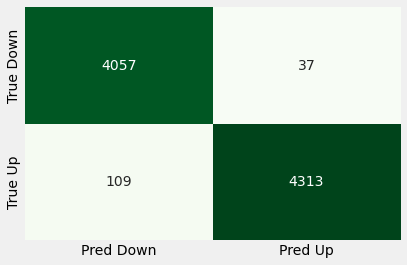

In [217]:
# plot confusion matrix
import seaborn as sns
import matplotlib.style as style


sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt="d",cmap="Greens",cbar=False, xticklabels=["Pred Down", "Pred Up"], yticklabels=["True Down", "True Up"])


<AxesSubplot:>

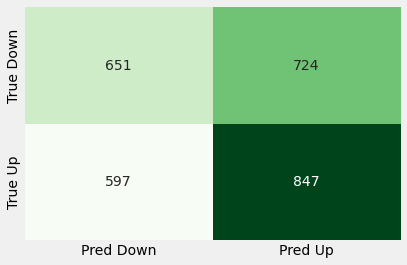

In [218]:

# with labels
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens",cbar=False, xticklabels=["Pred Down", "Pred Up"], yticklabels=["True Down", "True Up"])


In [219]:
# get precision and recall
from sklearn.metrics import precision_recall_fscore_support

# precision recall f1 score support
precision_recall_fscore_support(y_test, y_pred, average="macro")

(0.5303908277432308, 0.530009821203727, 0.5291177863383552, None)

In [224]:
# get all true positive rows from test
true_pos = y_test[(y_test == 1) & (y_pred == 1)]

In [241]:
# get rows from test where true positive and predicted positive
true_pos = test[(y_test == 1) & (y_pred == 1)]

In [228]:
true_pos

,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,...,Gross Profit/Total Assets,Short-Term Debt/Total Debt,Total Debt/Equity,Interest Coverage Ratio,Cash Ratio,Quick Ratio (Acid Test),Current Ratio,Labor Expenses/Sales,Dividend Yield,Predicted Next CPI Diff
521852,1.155582,-0.209221,0.672891,-0.107169,-0.222601,-0.097883,-1.946159,17.616225,-2.243044,5.106185,...,0.039,0.489,9.257,0.000,0.000,0.000,0.000,0.384,1.69,0.262641
521993,0.981305,0.956979,0.766264,0.036641,-0.269978,-0.204161,5.487825,6.400061,4.238314,2.602491,...,0.146,0.578,0.316,-31.690,2.042,4.028,4.028,0.000,4.26,0.262641
522069,0.950224,0.114913,1.120500,0.047610,-0.331995,-0.049959,-2.537005,12.649456,1.065969,7.551255,...,0.042,0.544,6.044,0.000,0.000,0.000,0.000,0.335,2.12,0.262641
522077,0.916378,0.120469,0.844099,0.401272,-0.163955,-0.154628,-2.441287,12.831000,1.213110,5.873957,...,0.045,0.483,10.055,0.000,0.000,0.000,0.000,0.378,1.68,0.262641
522120,0.768294,1.032099,-0.118404,0.611332,0.840366,-0.271309,5.284225,4.685802,4.355940,-0.370691,...,0.119,0.000,7.657,2.240,0.385,2.103,2.103,0.000,0.00,0.262641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631922,2.172577,15.114146,4.479457,2.342208,6.287715,-3.533877,-93.460304,3.932252,5.498149,4.358231,...,0.259,0.101,3.893,-10.750,0.493,1.271,1.271,0.000,0.00,-2.153549
631930,2.587301,16.370876,3.552901,1.501089,4.855855,-2.672622,-99.716469,14.544138,9.350065,6.643533,...,0.286,0.150,0.700,0.000,2.183,2.639,2.742,0.000,0.00,-2.153549
631981,1.190387,0.591105,1.552214,-0.014089,-0.521037,-0.008373,-4.097502,8.511089,3.074191,6.756559,...,0.036,0.499,9.395,0.000,0.000,0.000,0.000,0.396,2.98,-2.153549
632478,0.875133,0.993263,0.272717,0.870848,-0.441547,0.083505,-3.539675,6.404314,4.318228,1.212950,...,0.563,0.184,2.216,8.243,0.926,1.312,2.253,0.000,4.58,-2.153549


In [229]:
beta_t_price_macros_ratios_forecast_cpi

,date,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,Mkt-RF_t_stat,SMB_t_stat,...,Gross Profit/Total Assets,Short-Term Debt/Total Debt,Total Debt/Equity,Interest Coverage Ratio,Cash Ratio,Quick Ratio (Acid Test),Current Ratio,Labor Expenses/Sales,Dividend Yield,Predicted Next CPI Diff
0,1990-03-31,1.038365,0.791538,-0.585981,0.502075,0.845558,-0.007962,-0.512074,6.762754,3.458632,...,0.310,0.621,1.070,5.215,0.038,0.973,2.223,0.000,1.60,0.852853
1,1990-03-31,0.388108,1.916327,0.935567,-1.220024,-1.208725,-0.442404,-1.357494,1.149679,2.932208,...,0.319,0.144,4.203,1.993,0.019,0.902,1.165,0.000,3.88,0.852853
2,1990-03-31,0.736748,1.968293,2.354058,-0.289124,-3.483711,2.030655,-10.224021,1.106182,1.498568,...,0.324,0.006,1.998,-1.948,0.196,0.619,1.556,0.000,0.00,0.852853
3,1990-03-31,1.170401,0.265880,-0.211249,0.070628,0.126228,0.355568,-0.972948,5.240877,0.656788,...,0.803,0.085,0.293,46.012,1.105,2.483,3.501,0.000,0.00,0.852853
4,1990-03-31,1.377861,3.167790,1.521754,0.504179,-1.440121,0.174453,5.073359,5.103663,7.798251,...,0.187,0.309,1.540,-1.630,0.197,1.574,1.708,0.000,0.00,0.852853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633056,2022-09-30,2.183951,3.095228,-1.807697,-0.401592,2.618886,1.021018,14.632167,2.418348,1.957486,...,0.141,0.109,0.397,-4.776,0.229,0.763,2.668,0.000,0.00,-2.153549
633057,2022-09-30,1.673884,2.859076,-4.842351,-2.257226,6.191815,-0.210673,6.815112,1.298995,1.267179,...,0.336,0.358,0.555,0.000,2.642,2.795,2.795,0.000,0.00,-2.153549
633058,2022-09-30,-0.199904,2.286593,2.172833,-1.110223,-2.358458,-0.209070,-15.042500,-0.217468,1.160789,...,-0.915,0.397,-2.179,-12.697,0.565,0.635,0.635,0.000,0.00,-2.153549
633059,2022-09-30,-1.765071,-7.453946,-4.164327,-2.521602,-3.087937,-0.701556,25.310194,-0.754390,-1.161707,...,-0.126,0.730,0.510,-8.254,0.316,1.394,1.399,0.698,0.00,-2.153549


In [231]:
stocks

,gvkey,iid,datadate,tic,cusip,conm,dvrate,cshtrm,prccm,trfm,...,cshom,exchg,cik,ggroup,gind,gsector,gsubind,sic,spcindcd,spcseccd
96,1001,01,1983-10-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,370700.0,6.750,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
97,1001,01,1983-11-30,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,198000.0,8.000,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
98,1001,01,1983-12-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,176500.0,7.250,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
99,1001,01,1984-01-31,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,160800.0,8.000,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
100,1001,01,1984-02-29,AMFD.,000165100,A & M FOOD SERVICES INC,NaN,92400.0,6.500,1.0,...,NaN,14.0,723576.0,2530.0,253010.0,25.0,25301040.0,5812.0,420.0,978.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7677798,353444,90,2022-12-31,HLN,405552100,HALEON PLC,NaN,199074059.0,8.000,1.0,...,9.234574e+09,11.0,NaN,3030.0,303020.0,30.0,30302010.0,2834.0,NaN,NaN
7677799,353444,90,2023-01-31,HLN,405552100,HALEON PLC,NaN,76238800.0,8.100,1.0,...,9.234574e+09,11.0,NaN,3030.0,303020.0,30.0,30302010.0,2834.0,NaN,NaN
7677801,353945,90,2022-11-30,ACLLY,00449R109,ACCELLERON INDUSTRIES AG,NaN,NaN,20.178,1.0,...,9.450000e+07,19.0,1948862.0,2010.0,201040.0,20.0,20104020.0,3621.0,NaN,NaN
7677802,353945,90,2022-12-31,ACLLY,00449R109,ACCELLERON INDUSTRIES AG,NaN,NaN,20.693,1.0,...,9.450000e+07,19.0,1948862.0,2010.0,201040.0,20.0,20104020.0,3621.0,NaN,NaN


In [232]:
beta_t_price

,date,gvkey,const,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,const_t_stat,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,RMW_t_stat,CMA_t_stat,UMD_t_stat,CPI Diff_t_stat,prccm,next prccm
0,1984-03-31,1001,1.617369,2.816987,2.802663,-1.072653,-1.026270,1.418310,-6.042002,2.715491,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,6.3750,5.7500
1,1984-06-30,1001,-34.863852,-4.511405,28.574769,-21.044445,21.904572,65.009106,-20.285119,-62.786795,-2.943242,-1.488544,3.021764,-2.850274,3.164111,3.163528,-3.218833,-2.767972,5.7500,4.6250
2,1984-09-30,1001,-9.749395,1.823513,1.335508,-0.624966,3.187889,8.838945,0.939543,8.321742,-1.068479,0.915235,0.265933,-0.172691,0.606892,1.234692,0.287985,0.391423,4.6250,3.7500
3,1984-12-31,1001,-6.129191,1.606062,1.761768,0.353947,1.459742,4.687031,0.816065,3.462071,-0.805006,0.827017,0.385017,0.103271,0.338221,0.784437,0.299784,0.185480,3.7500,5.5000
4,1985-03-31,1001,-0.087791,0.725015,5.974105,0.691378,0.633958,1.776610,-0.793916,1.508161,-0.013529,0.406735,1.669880,0.216568,0.153218,0.373747,-0.356487,0.088519,5.5000,6.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067452,2022-06-30,351590,-2.024693,2.301945,0.231034,1.831006,4.158512,-1.592552,0.775537,0.173058,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,13.0210,11.4370
2067453,2022-09-30,351590,-14.698540,2.770672,14.970408,7.275495,2.357234,4.499387,-0.544222,-119.320140,-7.563526,8.676555,4.763186,7.578787,4.867750,2.962496,-0.765615,-5.012546,11.4370,15.4460
2067455,2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.4866,0.6400
2067456,2022-09-30,352257,25.275751,-0.480670,-5.173055,-2.878188,-5.391751,9.997307,-14.732755,-1.171518,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.6400,0.2877


In [234]:
true_pos

,Mkt-RF,SMB,HML,RMW,CMA,UMD,CPI Diff,Mkt-RF_t_stat,SMB_t_stat,HML_t_stat,...,Gross Profit/Total Assets,Short-Term Debt/Total Debt,Total Debt/Equity,Interest Coverage Ratio,Cash Ratio,Quick Ratio (Acid Test),Current Ratio,Labor Expenses/Sales,Dividend Yield,Predicted Next CPI Diff
521852,1.155582,-0.209221,0.672891,-0.107169,-0.222601,-0.097883,-1.946159,17.616225,-2.243044,5.106185,...,0.039,0.489,9.257,0.000,0.000,0.000,0.000,0.384,1.69,0.262641
521993,0.981305,0.956979,0.766264,0.036641,-0.269978,-0.204161,5.487825,6.400061,4.238314,2.602491,...,0.146,0.578,0.316,-31.690,2.042,4.028,4.028,0.000,4.26,0.262641
522069,0.950224,0.114913,1.120500,0.047610,-0.331995,-0.049959,-2.537005,12.649456,1.065969,7.551255,...,0.042,0.544,6.044,0.000,0.000,0.000,0.000,0.335,2.12,0.262641
522077,0.916378,0.120469,0.844099,0.401272,-0.163955,-0.154628,-2.441287,12.831000,1.213110,5.873957,...,0.045,0.483,10.055,0.000,0.000,0.000,0.000,0.378,1.68,0.262641
522120,0.768294,1.032099,-0.118404,0.611332,0.840366,-0.271309,5.284225,4.685802,4.355940,-0.370691,...,0.119,0.000,7.657,2.240,0.385,2.103,2.103,0.000,0.00,0.262641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631922,2.172577,15.114146,4.479457,2.342208,6.287715,-3.533877,-93.460304,3.932252,5.498149,4.358231,...,0.259,0.101,3.893,-10.750,0.493,1.271,1.271,0.000,0.00,-2.153549
631930,2.587301,16.370876,3.552901,1.501089,4.855855,-2.672622,-99.716469,14.544138,9.350065,6.643533,...,0.286,0.150,0.700,0.000,2.183,2.639,2.742,0.000,0.00,-2.153549
631981,1.190387,0.591105,1.552214,-0.014089,-0.521037,-0.008373,-4.097502,8.511089,3.074191,6.756559,...,0.036,0.499,9.395,0.000,0.000,0.000,0.000,0.396,2.98,-2.153549
632478,0.875133,0.993263,0.272717,0.870848,-0.441547,0.083505,-3.539675,6.404314,4.318228,1.212950,...,0.563,0.184,2.216,8.243,0.926,1.312,2.253,0.000,4.58,-2.153549


In [242]:
# merge true_pos with beta_t_price_macros_ratios_forecast_cpi on every intersection of columns
temp = pd.merge(true_pos, beta_t_price, on=['SMB',	'HML',	'RMW',	'CMA',	'UMD'])

In [245]:
temp["quarter_return"] = (temp["next prccm"] - temp["prccm"]) /  temp["prccm"]

In [247]:
temp["quarter_return"].mean()

0.29590925158243697

In [251]:
temp["quarter_return"].median()

0.1213949942828104

In [702]:
# test and pred
confusion_matrix([1,0,1], [1,1,1])


array([[0, 1],
       [0, 2]])

# Feature Importance

<AxesSubplot:xlabel='importance', ylabel='feature'>

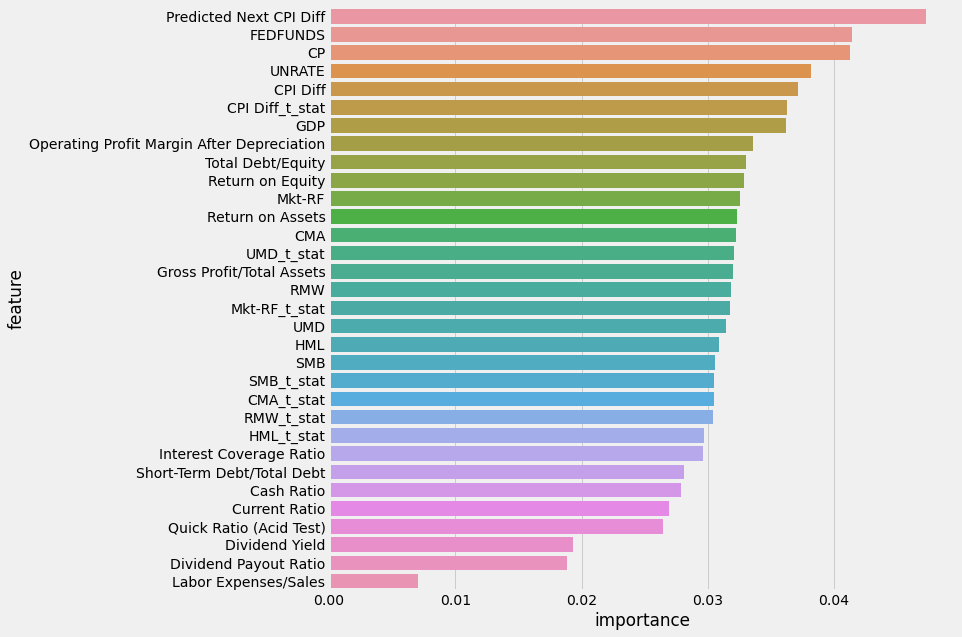

In [260]:
# get feature importance readable as plot
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": model.feature_importances_})
feature_importance.sort_values("importance", ascending=False)

# plot feature importance, make plot bigger
plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values("importance", ascending=False))

<AxesSubplot:xlabel='importance', ylabel='feature'>

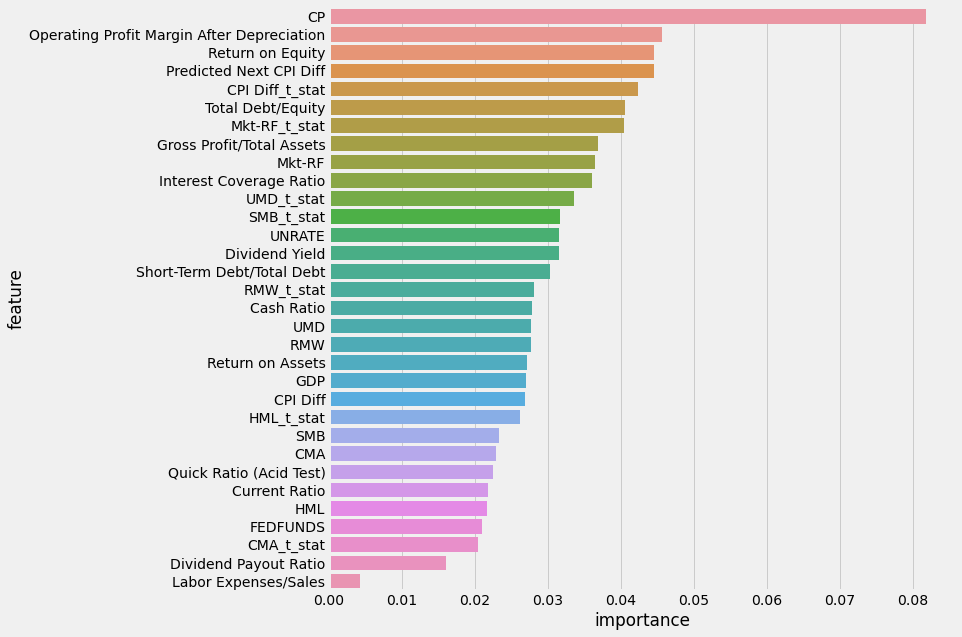

In [261]:
# get feature importance readable
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": dt.feature_importances_})
feature_importance.sort_values("importance", ascending=False)

# plot feature importance, make plot bigger
plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values("importance", ascending=False))

In [ ]:
# # shap values for rf model
# import shap

# # load JS visualization code to notebook
# shap.initjs()

# # explain the model's predictions using SHAP values
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_train)

# # summarize the effects of all the features
# shap.summary_plot(shap_values[1], X_train)


In [ ]:
'''
maybe need to add:

CPI/Forecast CPI level
SP500 percent change
5-year breakeven if we can see if it is simliar
recent trend of CPI

'''

In [347]:
forecast

,TIME,Forecast Inflation,date,prediction date
0,1961-Q1,1.508107,1960-12-31,1960-09-30
1,1961-Q2,0.867899,1961-03-31,1960-12-31
2,1961-Q3,1.205362,1961-06-30,1961-03-31
3,1961-Q4,0.705171,1961-09-30,1961-06-30
4,1962-Q1,0.893655,1961-12-31,1961-09-30
...,...,...,...,...
251,2023-Q4,3.063185,2023-09-30,2023-06-30
252,2024-Q1,2.833065,2023-12-31,2023-09-30
253,2024-Q2,2.623820,2024-03-31,2023-12-31
254,2024-Q3,2.475013,2024-06-30,2024-03-31


In [395]:
sig_stocks["target"].value_counts(normalize=True)

0    0.517168
1    0.482832
Name: target, dtype: float64

In [150]:
# get value counts of y test and y train as percentages
print(y_test.value_counts(normalize=True))
print(y_train.value_counts(normalize=True))

1    0.512238
0    0.487762
Name: target, dtype: float64
1    0.519258
0    0.480742
Name: target, dtype: float64


# Roc

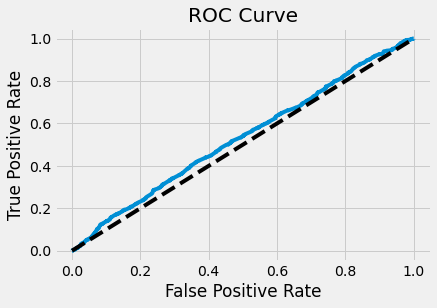

In [361]:
# get predict prob of test
y_pred_prob = rf.predict_proba(X_test)

# import roc curve
from sklearn.metrics import roc_curve

# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

# import matplotlib
import matplotlib.pyplot as plt

# plot roc curve
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Probabilities

(array([ 16.,  71., 340., 749., 818., 522., 261.,  42.]),
 array([0.1       , 0.19410714, 0.28821429, 0.38232143, 0.47642857,
        0.57053571, 0.66464286, 0.75875   , 0.85285714]),
 <BarContainer object of 8 artists>)

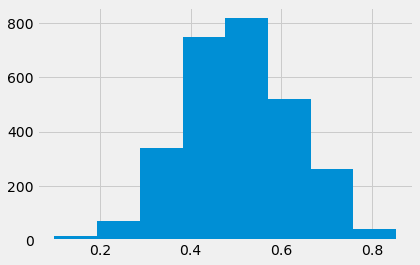

In [362]:
# histogram of y_pred_prob
plt.hist(y_pred_prob[:,1], bins=8)

(array([ 42., 261., 522., 818., 749., 340.,  71.,  16.]),
 array([0.14714286, 0.24125   , 0.33535714, 0.42946429, 0.52357143,
        0.61767857, 0.71178571, 0.80589286, 0.9       ]),
 <BarContainer object of 8 artists>)

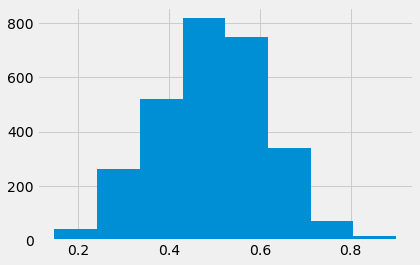

In [363]:
plt.hist(y_pred_prob[:,0], bins=8)

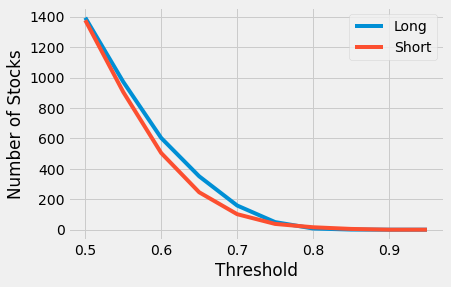

In [372]:
# range .5-1 with 0.05 increments
thresholds = np.arange(0.5, 1, 0.05)

long_len = []
short_len = []

for threshold in thresholds:
    long_len.append(len(y_pred_prob[y_pred_prob[:,1] > threshold]))
    short_len.append(len(y_pred_prob[y_pred_prob[:,0] > threshold]))


# plot long and short length
plt.plot(thresholds, long_len, label="Long")
plt.plot(thresholds, short_len, label="Short")
plt.xlabel("Threshold")
plt.ylabel("Number of Stocks")
plt.legend()
plt.show()

# save to dataframe
threshold_df = pd.DataFrame({"threshold": thresholds, "long": long_len, "short": short_len})

In [373]:
threshold_df

,threshold,long,short
0,0.50,1394,1377
1,0.55,972,905
2,0.60,603,504
3,0.65,351,246
4,0.70,159,102
5,0.75,50,38
6,0.80,8,16
7,0.85,1,5
8,0.90,0,0
9,0.95,0,0


In [377]:
# get number of probabilities that are greater than .75 for 1
len(y_pred_prob[y_pred_prob[:,1] > .7])

159

In [378]:
len(y_pred_prob[y_pred_prob[:,0] > .7])

102

In [387]:
# get predict prob of test
y_pred_prob = rf.predict_proba(X_test)

In [388]:

# get pred prob of true positive
y_pred_prob_true_pos = y_pred_prob[(y_test == 1) & (y_pred == 1)][:,1]

# get pred prob of true negative
y_pred_prob_true_neg = y_pred_prob[(y_test == 0) & (y_pred == 0)][:,0]

In [389]:
y_pred_prob_true_pos.mean()

0.5866428938859495

In [390]:
y_pred_prob_true_neg.mean()

0.5725962708220448

# Inflation Expectation effect on market

In [ ]:
sp500 = pd.read_excel("data/S&P_1990.xlsx")
five_year_be = pd.read_csv("data/T5YIE.csv")

In [328]:
sp500["year-month"] = sp500["Year"].astype(str) + "-" + sp500["Month"].astype(str)

sp500["year-month"] = pd.to_datetime(sp500["year-month"])


In [329]:
sp500.set_index("year-month", inplace=True)

In [330]:
# date to datetime
five_year_be["DATE"] = pd.to_datetime(five_year_be["DATE"])

In [331]:
five_year_be.set_index("DATE", inplace=True)

In [332]:
y = sp500["Return (%)"]

In [333]:
X = five_year_be["T5YIE"]

In [334]:
# X from string with . to float
X = pd.to_numeric(X,errors='coerce')


In [335]:
# get nans
X.isna().sum()

215

In [336]:
y.isna().sum()

0

In [337]:
y

year-month
1990-01-01   -0.0253
1990-02-01    0.0271
1990-03-01    0.0020
1990-04-01    0.0385
1990-05-01    0.0317
               ...  
2022-09-01   -0.0309
2022-10-01    0.0529
2022-11-01    0.0001
2022-12-01    0.0138
2023-01-01    0.0553
Name: Return (%), Length: 397, dtype: float64

In [338]:
X.dropna(inplace=True)

In [339]:
X.index

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-23', '2023-01-24', '2023-01-25', '2023-01-26',
               '2023-01-27', '2023-01-30'],
              dtype='datetime64[ns]', name='DATE', length=5023, freq=None)

In [340]:
# get intersection of indices
X = X[X.index.isin(y.index)]

In [341]:
y = y[y.index.isin(X.index)]

In [342]:
y

year-month
2003-04-01    0.0531
2003-05-01    0.0570
2003-07-01   -0.0017
2003-08-01    0.0316
2003-10-01    0.0121
               ...  
2022-07-01    0.0645
2022-08-01   -0.0728
2022-09-01   -0.0309
2022-11-01    0.0001
2022-12-01    0.0138
Name: Return (%), Length: 155, dtype: float64

In [343]:
X

DATE
2003-04-01    1.64
2003-05-01    1.30
2003-07-01    1.45
2003-08-01    1.75
2003-10-01    1.84
              ... 
2022-07-01    2.60
2022-08-01    2.72
2022-09-01    2.52
2022-11-01    2.65
2022-12-01    2.45
Name: T5YIE, Length: 155, dtype: float64

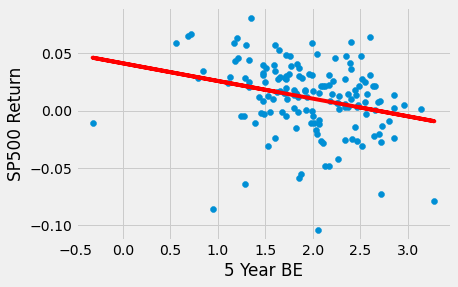

In [344]:
# run regression between sp500 and five year be
import statsmodels.api as sm

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

# plot regression
plt.scatter(X["T5YIE"], y)
plt.plot(X["T5YIE"], predictions, color="red")
plt.xlabel("5 Year BE")
plt.ylabel("SP500 Return")
plt.show()

In [345]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Return (%)   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     12.50
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           0.000539
Time:                        14:24:21   Log-Likelihood:                 324.65
No. Observations:                 155   AIC:                            -645.3
Df Residuals:                     153   BIC:                            -639.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0413      0.009      4.676      0.000       0.024       0.059
T5YIE         -0.0154      0.004     -3.535      0.001      -0.024      -0.007
==============================================================================
Omnibus:                       33.786   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.494
Skew:                          -1.062   Prob(JB):                     3.28e-13
Kurtosis:                       5.096   Cond. No.                         9.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([ 1.,  0.,  3.,  4., 19., 39., 36., 32., 18.,  3.]),
 array([-0.32,  0.04,  0.4 ,  0.76,  1.12,  1.48,  1.84,  2.2 ,  2.56,
         2.92,  3.28]),
 <BarContainer object of 10 artists>)

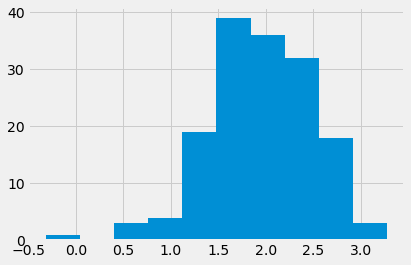

In [346]:
# histo X
plt.hist(X["T5YIE"])